### Data has been taken from [Analytics Vidya](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/)

### Problem Statement

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

### Evaluation Metric:

The metric used for evaluating the performance of classification model would be F1-Score.

 

The metric can be understood as -

 

#### True Positives (TP):
These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.

#### True Negatives (TN):
These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.

#### False Positives (FP):
When actual class is no and predicted class is yes.

#### False Negatives (FN):
When actual class is yes but predicted class in no.

#### Precision = TP/TP+FP

#### Recall = TP/TP+FN

 

#### F1 Score = 2*(Recall * Precision) / (Recall + Precision)

<b> Here, I'm going to use all the implementation using numpy, pandas and scikit-learn library.</b>

In [1]:
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_recall_curve, precision_score
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [2]:
%matplotlib inline

In [3]:
train_= pd.read_csv('train.csv')
test_= pd.read_csv('test.csv')

In [4]:
train, test= train_.copy(), test_.copy()

In [5]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [6]:
#Glimpse of data
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
for i, tweet in enumerate(train['tweet'][:5]):
    print(i, ' ', tweet)

0    @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
1   @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
2     bihday your majesty
3   #model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
4    factsguide: society now    #motivation


In [8]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


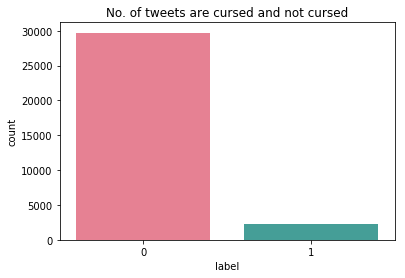

In [9]:
#check out the how many tweets are cursee or not cursed
sns.countplot('label', data= train, palette= 'husl')
plt.title('No. of tweets are cursed and not cursed')
plt.show()

In [10]:
train['label'].value_counts(normalize= True)

0    0.929854
1    0.070146
Name: label, dtype: float64

The dataset is highly imbalanced, there are large gap between the positive and negative results. As per the diagram we can say very small no. of people are used bad words in tweets.

### First Approach (Simple Approach)
<b> Here, I'm not going to use vectorization of word, count vectorizer, etc.
    I'm using
    1. length of tweets (original)
    2. no. of punctuation
    3. no. of stopwords
    4. no. of hash tags
    5. no. of callouts
    6. length of tweet (after removing the puctuation and stopwords)
    7. average length of word in tweet
    Thats all for the first approach.
</b>

In [11]:
#created new feature length of tweets
train['len_tweet']= train['tweet'].apply(lambda x: len(x))
test['len_tweet']= test['tweet'].apply(lambda x: len(x))

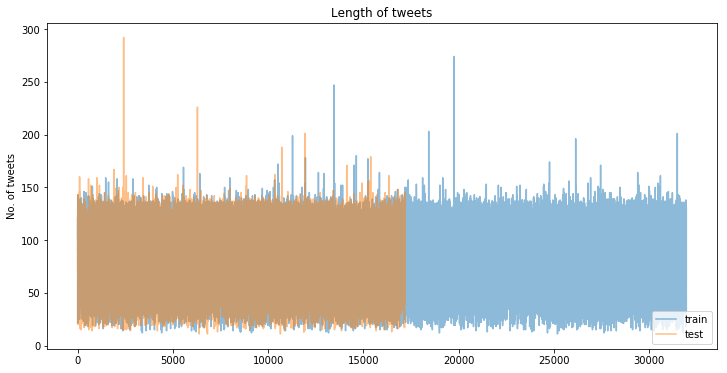

In [12]:
#plot the length of the tweets
plt.figure(figsize= (12, 6))
plt.plot(train['len_tweet'], lw= 1.5, label= 'train', alpha= 0.5)
plt.plot(test['len_tweet'], lw= 1.5, label= 'test', alpha= 0.5)
plt.ylabel('No. of tweets')
plt.title('Length of tweets')
plt.legend(loc= 4)
plt.show()

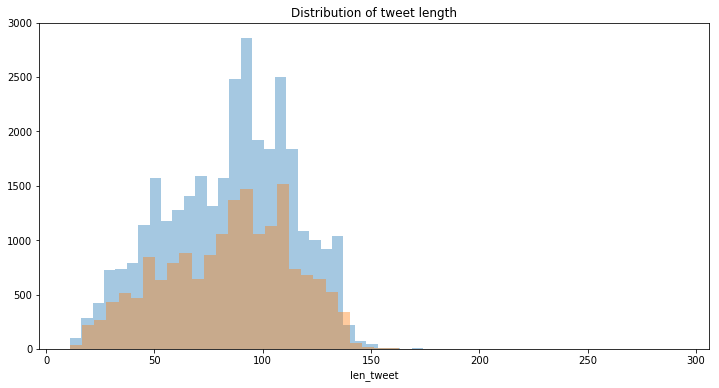

In [13]:
plt.figure(figsize= (12, 6))
sns.distplot(train['len_tweet'], bins= 50, kde= False)
sns.distplot(test['len_tweet'], bins= 50, kde= False)
plt.title('Distribution of tweet length')
plt.show()

In [14]:
#checkout the description of tweet length of train and test dataset
print('Train dataset: ')
print(train['len_tweet'].describe())
print('--------------------------------------------------')
print('Test dataset: ')
print(test['len_tweet'].describe())

Train dataset: 
count    31962.000000
mean        84.739628
std         29.455749
min         11.000000
25%         63.000000
50%         88.000000
75%        108.000000
max        274.000000
Name: len_tweet, dtype: float64
--------------------------------------------------
Test dataset: 
count    17197.000000
mean        84.546374
std         29.606621
min         11.000000
25%         62.000000
50%         88.000000
75%        108.000000
max        292.000000
Name: len_tweet, dtype: float64


In [15]:
def len_word_tweet(tweets):
    
    avg_len_word= []
    word_len= []
    #the definition of the function that describe the length of average words in a tweets
    for tweet in tweets:
        tweet= tweet.lower().strip().split(' ')
        #for w in tweet:
            #word_len.append(len(w))
        word_len= [len(w) for w in tweet]
        avg_len_word.append(np.mean(word_len))
        
    return avg_len_word

In [16]:
avg_len_word_train= len_word_tweet(train['tweet'])
avg_len_word_test= len_word_tweet(test['tweet'])

In [17]:
train['avg_len_word']= avg_len_word_train
test['avg_len_word']= avg_len_word_test

In [18]:
#consider hash (#) tags i.e. no. of hash tag used
def consider_hash_tag(tweets): #pass the tweets
    hash_element= [] #create list for the word with #tag
    count_hash= [] #create list for the no. of hash tag used
    for tweet in tweets:
        tweet_word= tweet.strip().split(' ')   #remove whitespace and split
        hash_word= [h for h in tweet_word if h.startswith('#')] #hash tag present in particular tweet
        count= len(hash_word) #no. of hash tag present in particulat tweets
        hash_element.append(hash_word)
        count_hash.append(count)
        
    
    return hash_element, count_hash  #return both the #tag word as well as no. of #tag

In [19]:
hash_tag_train, count_tag_train= consider_hash_tag(train['tweet'])
hash_tag_test, count_tag_test= consider_hash_tag(test['tweet'])

In [20]:
#create another feature of no. of #tag used
train['no_of_hash_tag']= count_tag_train
test['no_of_hash_tag']= count_tag_test

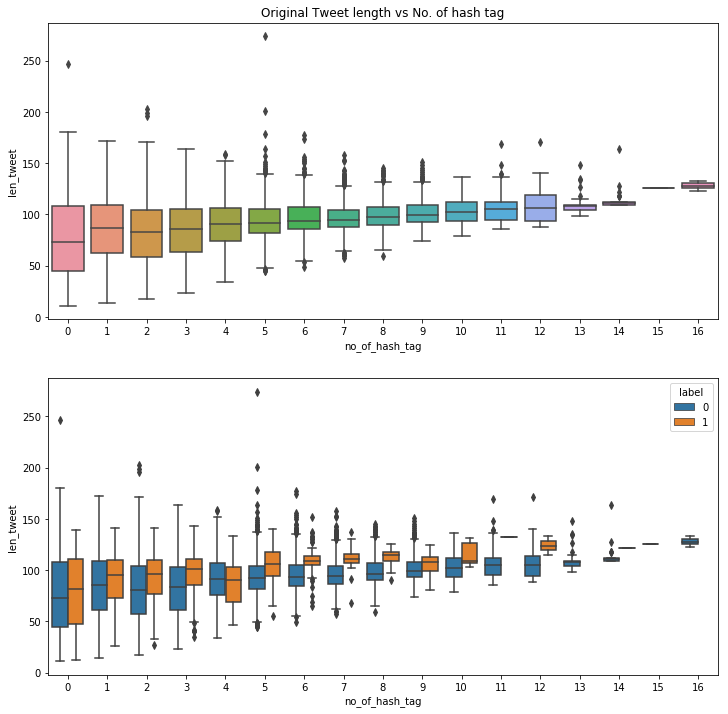

In [21]:
#check the hash and a length of tweet using the box plot
plt.figure(figsize= (12, 12))
plt.subplot(211)
sns.boxplot('no_of_hash_tag', 'len_tweet', data= train)
plt.title('Original Tweet length vs No. of hash tag')

plt.subplot(212)
sns.boxplot('no_of_hash_tag', 'len_tweet', data= train, hue= 'label')

plt.show()

In [22]:
#checkout the #of callouts used in particular tweets
def no_of_callout(tweets):
    no_of_callouts= []
    
    for tweet in tweets:
        tweet= tweet.lower().strip().split(' ')
        callouts= [w for w in tweet if w.startswith('@')] #consider the word those startswith the @
        no_of_callouts.append(len(callouts))
        
    return no_of_callouts

In [23]:
no_callouts_train= no_of_callout(train['tweet'])
no_callouts_test= no_of_callout(test['tweet'])

In [24]:
train['no_of_callouts']= no_callouts_train
test['no_of_callouts']= no_callouts_test

In [25]:
def no_of_punctuation(tweets):
    len_punc= []
    
    for tweet in tweets:
        tweet= tweet.lower().strip().split(' ')
        
        punc= [w for w in tweet if w in punctuation]
        len_punc.append(len(punc))
        
    return len_punc

In [26]:
len_punc_train= no_of_punctuation(train['tweet'])
len_punc_test= no_of_punctuation(test['tweet'])

In [27]:
train['punctuation']= len_punc_train
test['punctuation']= len_punc_test

In [28]:
def no_of_stopwords(tweets):
    len_sw= []
    
    for tweet in tweets:
        tweet= tweet.lower().strip().split(' ')
        
        sw= [w for w in tweet if w in ENGLISH_STOP_WORDS]
        len_sw.append(len(sw))
        
    return len_sw

In [29]:
len_sw_train= no_of_stopwords(train['tweet'])
len_sw_test= no_of_stopwords(test['tweet'])

In [30]:
train['stopwords']= len_sw_train
test['stopwords']= len_sw_test

#### Drop the tweet and id features from train and test data

In [31]:
train_1= train.drop(['id', 'tweet'], axis= 1)
test_1= test.drop(['id', 'tweet'], axis= 1)

#### Checkout the correlation between the features

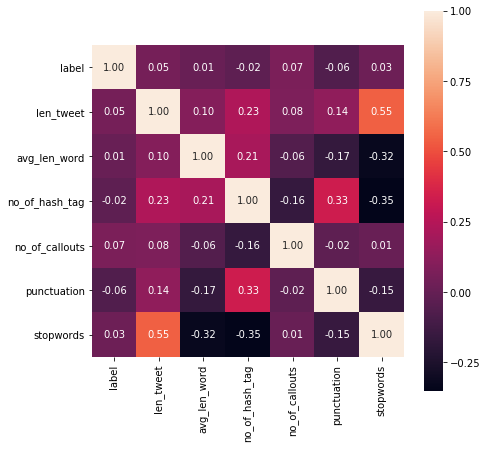

In [32]:
corr= train_1.corr()
plt.figure(figsize= (7, 7))
sns.heatmap(corr, annot= True, fmt= '.2f', square= True)
plt.show()

#### Now time to do Machine Learning Modeling

In [33]:
#split the data in train and validation data using the train_test_split
X_train, X_test, y_train, y_test= train_test_split(train_1.drop(['label'], axis= 1), train_1['label'], random_state= 101)

#### Models

In [34]:
clf_log= LogisticRegression(class_weight= 'balanced', random_state= 101) #given class weight because of imbalanced data
#clf_svm= SVC(kernel= 'linear', random_state= 101)
clf_knn= KNeighborsClassifier()
clf_gnb= GaussianNB()
clf_bnb= BernoulliNB()
clf_rf= RandomForestClassifier(random_state= 101)
clf_gbc= GradientBoostingClassifier(random_state= 101)
clf_lda= LinearDiscriminantAnalysis()

In [35]:
clfs= [clf_log, clf_knn, clf_gnb, clf_bnb, clf_rf, clf_gbc, clf_lda]
names= ['LogisticRegression', 'KNeighborsClassifier', 'GaussianNB', 'BernoulliNB',
        'RandomForestClassifier', 'GradientBoostingClassifier', 'LinearDiscriminantAnalysis']

In [36]:
result_df= pd.DataFrame()

acc_train= []
acc_test= []
f1_score_= []
for clf in clfs:
    clf.fit(X_train, y_train)
    
    prediction= clf.predict(X_test)
    
    #find the accuracies
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(accuracy_score(y_test, prediction))
    f1_score_.append(f1_score(y_test, prediction))
    
result_df['Model']= names
result_df['Accuracy_train']= acc_train
result_df['Accuracy_test']= acc_test
result_df['f1_Score']= f1_score_

result_df

C:\Users\sngupta\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Model,Accuracy_train,Accuracy_test,f1_Score
0,LogisticRegression,0.637395,0.631085,0.170045
1,KNeighborsClassifier,0.939761,0.928419,0.163743
2,GaussianNB,0.917192,0.920160,0.044910
3,BernoulliNB,0.928914,0.932674,0.000000
4,RandomForestClassifier,0.989154,0.931673,0.287206
5,GradientBoostingClassifier,0.934880,0.935552,0.154351
6,LinearDiscriminantAnalysis,0.928831,0.932424,0.000000


Accuracy Score (train): 0.9886112385799508
Accuracy Score (test): 0.932924540107621
f1 Score: 0.3002610966057441
Weighted f1 score: 0.9200351034957926
Classification_report: 
             precision    recall  f1-score   support

          0       0.95      0.98      0.96      7453
          1       0.50      0.21      0.30       538

avg / total       0.92      0.93      0.92      7991



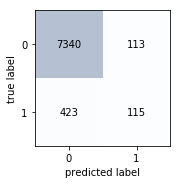

In [37]:
#Here, the randomforestclassifier works well
#lets tune the parameters

clf_rf_1= RandomForestClassifier(criterion= 'entropy', class_weight= 'balanced', random_state= 101)
clf_rf_1.fit(X_train, y_train)
pred_y= clf_rf_1.predict(X_test)

prediction= clf_rf_1.predict(test_1)

print('Accuracy Score (train): {}' .format(clf_rf_1.score(X_train, y_train)))
print('Accuracy Score (test): {}' .format(accuracy_score(y_test, pred_y)))
print('f1 Score: {}' .format(f1_score(y_test, pred_y)))
print('Weighted f1 score: {}' .format(f1_score(y_test, pred_y, average= 'weighted')))
print('Classification_report: ')
print(classification_report(y_test, pred_y))
#draw confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, pred_y))
plt.show()

In [38]:
#let check it by submitting what is actual score
samp_1= pd.DataFrame({
    'id': test['id'],
    'label': prediction
})

In [39]:
samp_1.to_csv('sample_1.csv', index= False)

### After submitting to the [site](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/), I got 30.45% as of f1_score metric.

### The result I got from that simple approach.

## Second Approach

### Lets try with the Vectorizer process i.e. Count Vectorizer, tfidf Vectorizer

In [40]:
#first of all I conatenate both the train and test dataset
df_train= pd.read_csv('train.csv')
df_test= pd.read_csv('test.csv')
#df_all= pd.concat([df_train, df_test])

In [41]:
df_train.shape, df_test.shape

((31962, 3), (17197, 2))

In [42]:
def ml_modeling(model, train, test, count_vectorizer= True, tfidf_vectorizer= True):
    X_train, X_test, y_train, y_test= train_test_split(train['tweet'], train['label'], random_state= 0)
    
    if count_vectorizer:
        print('Using Count Vectorizer')
        vect_count= CountVectorizer().fit(X_train)
        X_train_vect= vect_count.transform(X_train)
        
        model.fit(X_train_vect, y_train)
        
        predictions= model.predict(vect_count.transform(X_test))
        #pred_ori= model.predict(vect_count.transform(test['tweet']))
        #print accuracies
        print('Training Accuracy: {:.3f}' .format(model.score(X_train_vect, y_train)))
        print('Validation Accuracy: {:.3f}' .format(accuracy_score(y_test, predictions)))
        print('f1-Score: {:.4f}' .format(f1_score(y_test, predictions)))
        
        #get the feature with smallest coefs and largest coefs
        try:
            features_names= np.array(vect_count.get_feature_names())
            sorted_coef_index= model.coef_[0].argsort()
            print('---------------------------------------------------------------------------------------')
            print('Smallest Coefs: {}' .format(features_names[sorted_coef_index[:10]]))
            print('Largest Coefs: {}' .format(features_names[sorted_coef_index][:-11:-1]))

        except:
            pass

        print('--------------------------------------------------------------------------------------')
        print('Classfication Report: ')
        print(classification_report(y_test, predictions))
            
       
    print('-----------------------------------------------------------------------------------------')
    
    if tfidf_vectorizer:
        print('Using tfidf Vectorizer')
        vect_tfidf= TfidfVectorizer(min_df= 5).fit(X_train)
        X_train_tfidf= vect_tfidf.transform(X_train)
        
        model.fit(X_train_tfidf, y_train)
        
        predictions= model.predict(vect_tfidf.transform(X_test))
        #pred_ori= model.predict(vect_tfidf.transform(test['tweet']))
        #print accuracies
        print('Training Accuracy: {:.3f}' .format(model.score(X_train_tfidf, y_train)))
        print('Validation Accuracy: {:.3f}' .format(accuracy_score(y_test, predictions)))
        print('f1-Score: {:.4f}' .format(f1_score(y_test, predictions)))
        
        #get the feature with smallest coefs and largest coefs
        try:
            features_names= np.array(vect_tfidf.get_feature_names())
            sorted_coef_index= model.coef_[0].argsort()
            print('---------------------------------------------------------------------------------------')
            print('Smallest Coefs: {}' .format(features_names[sorted_coef_index[:10]]))
            print('Largest Coefs: {}' .format(features_names[sorted_coef_index][:-11:-1]))
            
        except:
            pass

        print('--------------------------------------------------------------------------------------')
        print('Classfication Report: ')
        print(classification_report(y_test, predictions))

In [43]:
clf_log= LogisticRegression(class_weight= 'balanced')

In [44]:
ml_modeling(clf_log, df_train, df_test)

Using Count Vectorizer
Training Accuracy: 0.989
Validation Accuracy: 0.952
f1-Score: 0.6701
---------------------------------------------------------------------------------------
Smallest Coefs: ['bihday' 'day' 'orlando' 'healthy' 'hardcore' 'smile' 'friday'
 'happiness' 'weekend' 'tomorrow']
Largest Coefs: ['allahsoil' 'bigot' 'racism' 'white' 'inauguration' 'racist' 'equality'
 '2017' 'blacklivesmatter' 'latest']
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

          0       0.98      0.97      0.97      7460
          1       0.62      0.73      0.67       531

avg / total       0.96      0.95      0.95      7991

-----------------------------------------------------------------------------------------
Using tfidf Vectorizer
Training Accuracy: 0.941
Validation Accuracy: 0.919
f1-Score: 0.5780
-------------------------------------------------------------------------

In [45]:
ml_modeling(clf_rf, df_train, df_test)

Using Count Vectorizer
Training Accuracy: 0.994
Validation Accuracy: 0.957
f1-Score: 0.5556
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      7460
          1       0.88      0.40      0.56       531

avg / total       0.95      0.96      0.95      7991

-----------------------------------------------------------------------------------------
Using tfidf Vectorizer
Training Accuracy: 0.994
Validation Accuracy: 0.957
f1-Score: 0.5781
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      7460
          1       0.83      0.44      0.58       531

avg / total       0.95      0.96      0.95      7991



In [46]:
ml_modeling(clf_bnb, df_train, df_test)

Using Count Vectorizer
Training Accuracy: 0.952
Validation Accuracy: 0.945
f1-Score: 0.3030
---------------------------------------------------------------------------------------
Smallest Coefs: ['00' 'ombre' 'omarmateen' 'omar' 'omalleyclan' 'omahpohon' 'omaha' 'om'
 'olympicstadium' 'olympics']
Largest Coefs: ['user' 'the' 'to' 'of' 'you' 'is' 'in' 'and' 'amp' 'are']
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      7460
          1       0.99      0.18      0.30       531

avg / total       0.95      0.95      0.93      7991

-----------------------------------------------------------------------------------------
Using tfidf Vectorizer
Training Accuracy: 0.953
Validation Accuracy: 0.945
f1-Score: 0.6051
---------------------------------------------------------------------------------------
Smallest Coefs: ['00' 'menu' 'me

In [47]:
ml_modeling(clf_rf_1, df_train, df_test)

Using Count Vectorizer
Training Accuracy: 0.993
Validation Accuracy: 0.956
f1-Score: 0.5217
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      7460
          1       0.94      0.36      0.52       531

avg / total       0.96      0.96      0.95      7991

-----------------------------------------------------------------------------------------
Using tfidf Vectorizer
Training Accuracy: 0.993
Validation Accuracy: 0.955
f1-Score: 0.5034
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      7460
          1       0.92      0.35      0.50       531

avg / total       0.95      0.95      0.94      7991



In [48]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
clf_dtc= DecisionTreeClassifier(random_state= 0)

In [50]:
ml_modeling(clf_dtc, df_train, df_test)

Using Count Vectorizer
Training Accuracy: 1.000
Validation Accuracy: 0.950
f1-Score: 0.5980
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

          0       0.97      0.98      0.97      7460
          1       0.64      0.56      0.60       531

avg / total       0.95      0.95      0.95      7991

-----------------------------------------------------------------------------------------
Using tfidf Vectorizer
Training Accuracy: 1.000
Validation Accuracy: 0.942
f1-Score: 0.5615
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      7460
          1       0.56      0.56      0.56       531

avg / total       0.94      0.94      0.94      7991



In [51]:
X_train, X_test, y_train, y_test= train_test_split(df_train['tweet'], df_train['label'], random_state= 0)

In [52]:
vect_count= CountVectorizer().fit(X_train)
X_train_vect= vect_count.transform(X_train)

clf_log.fit(X_train_vect, y_train)

predictions= clf_log.predict(vect_count.transform(X_test))
pred_ori= clf_log.predict(vect_count.transform(test['tweet']))
#print accuracies
print('Training Accuracy: {:.3f}' .format(clf_log.score(X_train_vect, y_train)))
print('Validation Accuracy: {:.3f}' .format(accuracy_score(y_test, predictions)))
print('f1-Score: {:.4f}' .format(f1_score(y_test, predictions)))

Training Accuracy: 0.989
Validation Accuracy: 0.952
f1-Score: 0.6701


In [53]:
samp_2= pd.DataFrame({
    'id': df_test['id'],
    'label': pred_ori
})

In [54]:
samp_2.to_csv('sample_2.csv', index= False)

## Third Approach

In [55]:
df_all= pd.concat([df_train, df_test])

In [56]:
#here, only I have tweets and now preprocess it
#defined function to remove all the patterns from the tweets
def remove_pattern(tweet, pattern):
    r= re.findall(pattern, tweet)
    for i in r:
        tweet= re.sub(i, '', tweet)
        
    return tweet

In [57]:
#removing callout @
df_all['clean_tweet']= np.vectorize(remove_pattern)(df_all['tweet'], '@[\w]*')

In [58]:
#removing punctuation, constants, special_characters
df_all['clean_tweet']= df_all['clean_tweet'].str.replace('[^a-zA-Z#]', ' ')

In [59]:
#remove short words
df_all['clean_tweet']= df_all['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [60]:
df_all.reset_index(inplace= True)
df_all.drop(['index'], axis= 1, inplace= True)

In [61]:
df_all['clean_tweet'][0]

'when father dysfunctional selfish drags kids into dysfunction #run'

In [62]:
#do tokenization
df_all['clean_tweet']= df_all['clean_tweet'].apply(lambda x: x.split())

In [63]:
df_all['clean_tweet'][0]

['when',
 'father',
 'dysfunctional',
 'selfish',
 'drags',
 'kids',
 'into',
 'dysfunction',
 '#run']

In [64]:
from nltk.stem.porter import *

In [65]:
stemmer= PorterStemmer()

In [66]:
df_all['clean_tweet']= df_all['clean_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])

In [67]:
df_all['clean_tweet'][0]

['when',
 'father',
 'dysfunct',
 'selfish',
 'drag',
 'kid',
 'into',
 'dysfunct',
 '#run']

In [68]:
df_all_1= df_all.copy()

In [69]:
df_all_1.drop(['id', 'tweet'], axis= 1, inplace= True)

In [70]:
train_clean= df_all_1[:len(df_train)]
test_clean= df_all_1[len(df_train):]

In [71]:
df_train.shape, df_test.shape, train_clean.shape, test_clean.shape

((31962, 3), (17197, 2), (31962, 2), (17197, 2))

In [72]:
train_clean.rename(columns= {'clean_tweet': 'tweet'}, inplace= True)
test_clean.rename(columns= {'clean_tweet': 'tweet'}, inplace= True)

C:\Users\sngupta\Anaconda3\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [73]:
train_clean['tweet']= train_clean['tweet'].apply(lambda x: ' '.join([w for w in x]))

C:\Users\sngupta\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
test_clean['tweet']= test_clean['tweet'].apply(lambda x: ' '.join([w for w in x]))

C:\Users\sngupta\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
ml_modeling(clf_log, train_clean, test_clean)

Using Count Vectorizer
Training Accuracy: 0.982
Validation Accuracy: 0.945
f1-Score: 0.6399
---------------------------------------------------------------------------------------
Smallest Coefs: ['bihday' 'orlando' 'hardcor' 'tomorrow' 'healthi' 'fathersday' 'life'
 'friday' 'weekend' 'excit']
Largest Coefs: ['allahsoil' 'bigot' 'racism' 'blacklivesmatt' 'white' 'latest' 'racist'
 'term' 'misogynist' 'fakenew']
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

        0.0       0.98      0.96      0.97      7460
        1.0       0.57      0.74      0.64       531

avg / total       0.95      0.94      0.95      7991

-----------------------------------------------------------------------------------------
Using tfidf Vectorizer
Training Accuracy: 0.943
Validation Accuracy: 0.923
f1-Score: 0.5810
-----------------------------------------------------------------------------

In [76]:
ml_modeling(clf_rf, train_clean, test_clean)

Using Count Vectorizer
Training Accuracy: 0.995
Validation Accuracy: 0.961
f1-Score: 0.6360
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      7460
        1.0       0.85      0.51      0.64       531

avg / total       0.96      0.96      0.96      7991

-----------------------------------------------------------------------------------------
Using tfidf Vectorizer
Training Accuracy: 0.994
Validation Accuracy: 0.961
f1-Score: 0.6423
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      7460
        1.0       0.82      0.53      0.64       531

avg / total       0.96      0.96      0.96      7991



In [77]:
ml_modeling(clf_rf_1, train_clean, test_clean)

Using Count Vectorizer
Training Accuracy: 0.995
Validation Accuracy: 0.958
f1-Score: 0.6024
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

        0.0       0.96      0.99      0.98      7460
        1.0       0.80      0.48      0.60       531

avg / total       0.95      0.96      0.95      7991

-----------------------------------------------------------------------------------------
Using tfidf Vectorizer
Training Accuracy: 0.994
Validation Accuracy: 0.958
f1-Score: 0.6263
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      7460
        1.0       0.78      0.53      0.63       531

avg / total       0.95      0.96      0.95      7991



In [78]:
ml_modeling(clf_bnb, train_clean, test_clean)

Using Count Vectorizer
Training Accuracy: 0.953
Validation Accuracy: 0.946
f1-Score: 0.3323
---------------------------------------------------------------------------------------
Smallest Coefs: ['aaaaa' 'opendata' 'opec' 'opc' 'opac' 'ooz' 'ooxg' 'ootn' 'ootd'
 'openfollow']
Largest Coefs: ['that' 'trump' 'thi' 'white' 'like' 'black' 'with' 'have' 'racist'
 'polit']
--------------------------------------------------------------------------------------
Classfication Report: 
             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97      7460
        1.0       0.95      0.20      0.33       531

avg / total       0.95      0.95      0.93      7991

-----------------------------------------------------------------------------------------
Using tfidf Vectorizer
Training Accuracy: 0.953
Validation Accuracy: 0.944
f1-Score: 0.5902
---------------------------------------------------------------------------------------
Smallest Coefs: ['aap' 'mensfashio

In [79]:
#using tfidf vectorizer
tf_idf= TfidfVectorizer(stop_words= 'english')
tf= tf_idf.fit_transform(df_all['clean_tweet'].apply(lambda x: ' '.join(x)))

In [80]:
tf

<49159x40053 sparse matrix of type '<class 'numpy.float64'>'
	with 309524 stored elements in Compressed Sparse Row format>

In [81]:
tf_train= tf[:len(df_train)]
tf_test= tf[len(df_train):]

In [82]:
label= train['label']

### Using tfidfvectorizer

In [83]:
#model building
X_train, X_test, y_train, y_test= train_test_split(tf_train, label, random_state= 101)

In [84]:
#vect_count= CountVectorizer().fit(X_train)
#X_train_vect= vect_count.transform(X_train)

clf_log.fit(X_train, y_train)

predictions= clf_log.predict(X_test)
pred_ori= clf_log.predict(tf_test)
#print accuracies
print('Training Accuracy: {:.3f}' .format(clf_log.score(X_train, y_train)))
print('Validation Accuracy: {:.3f}' .format(accuracy_score(y_test, predictions)))
print('f1-Score: {:.4f}' .format(f1_score(y_test, predictions)))

Training Accuracy: 0.966
Validation Accuracy: 0.945
f1-Score: 0.6621


#### I got overall best result by using the Logistic Regression Algorithm.